#LAB 4: Semantic segmentation



<h2><span style="color:blue">[ShinByeongGeun]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-11-16 14:16:46.863481


In [2]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models




## Introduction


### What is Semantic Segmentation?
#### Semantic segmentation is an approach to understand what is in the image in pixel-level:

- It is a lot more difficult than image classification, which makes a prediction in image-level.

- It differs from object detection in that it has no information about instances.

<img src="https://drive.google.com/uc?export=view&id=1Oe6OVIuT8WPxK4x0LXOunxL-tVtzg948" alt="no_image" style="width: 900px;"/>

Applications for semantic segmentation include:

- Autonomous driving

- Image Editing

- Classification of terrain visible in satellite imagery

- Medical imaging analysis

### 1. Semantic segmentation with CNNs
- Typical classification models (AlexNet, VGGNet, ...) take fixed-sized inputs and produce a probability vector. The fully connected layers of these models have fixed dimensions and throw away spatial coordinates.


- It is known that the fully connected layer can be viewed as a convolution layer with a kernel that covers only one pixel, that is, a 1x1 kernel. Thus, we can convert the fully connected layers into convolution layers with maintaining pre-trained weights.


- After 'convolutionalizing' fully connected layers, a feature map needs to be upsampled because of pooling operations in the models. Instead of using simple bilinear interpolation, we can use a transposed convolution layer to learn the interpolation process. This layer is also called as upconvolution, deconvolution or fractionally-strided convolution.

### 1.1 Pixel wise classification using sliding window

<img src="https://drive.google.com/uc?export=view&id=1RJOmD22NyRT-6T0hCQ5hbU3FB9Mpevyu" alt="no_image" style="width: 900px;"/>

### 1.1.1 Example with VGG-Net

**Load a test image**

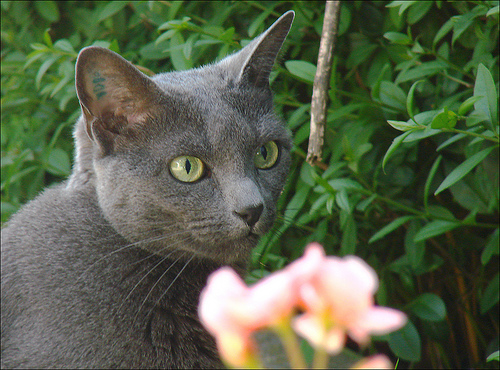

In [3]:
from PIL import Image
test_img_path = 'data/lab4/img/2009_005160.jpg'
test_img = Image.open(test_img_path)
test_img

**Standardization of the test image**

In [4]:
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_transform = transform(test_img).cuda().unsqueeze(0)
print(test_transform.size())

torch.Size([1, 3, 224, 224])


**Load VGG-Net**

In [5]:
import torchvision.models.vgg as vgg
imageNet = vgg.vgg16(pretrained=True).cuda()

/home/team116/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/team116/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import torch
import torch.nn as nn
with torch.no_grad():
    out = imageNet(test_transform)

out_class = torch.argmax(out)
print(out.size())
print(out_class) # 285 is egyptian cat in ImageNet

torch.Size([1, 1000])
tensor(285, device='cuda:0')


In [7]:
# padding
m = nn.ZeroPad2d((111,112,111,112))
pad_image = m(test_transform)
res = torch.zeros((224,224)).cuda()

In [8]:
# sliding window approach for segmentation
# NOTICE: It takes some time
for i in range(224):
    for j in range(224):
        patch = pad_image[:,:,i:i+224,j:j+224]
        # classify each pixels
        with torch.no_grad():
            res[i,j] = torch.argmax(imageNet(patch))

In [9]:
print(res)

tensor([[285., 285., 285.,  ..., 282., 282., 282.],
        [285., 285., 285.,  ..., 285., 285., 282.],
        [285., 285., 285.,  ..., 281.,  24.,  24.],
        ...,
        [150., 298., 150.,  ..., 299., 254.,  94.],
        [284., 285., 360.,  ..., 356., 254., 254.],
        [285., 284., 284.,  ..., 105., 356., 254.]], device='cuda:0')


**Visualize the output, classified as 'egyptian cat' (285)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].


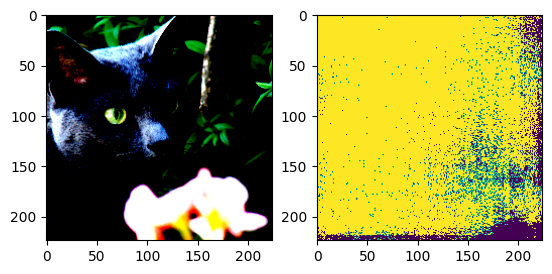

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(test_transform[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow((res==285).data.cpu().numpy()) # Visualize pixels classified as egyptian cat
plt.show()

- Inefficient & Ineffective !

### 1.2 Pixel wise classification using image classification

<img src="https://drive.google.com/uc?export=view&id=1XaspEEpplLzpNJ8qJpPN24qMeVmbsp5P" alt="no_image" style="width: 900px;"/>

#### 1.2.1 Convolutional VGG

In [11]:
import torchvision.models as models

class ConvolutionalVGG(nn.Module):
    def __init__(self):
        super(ConvolutionalVGG, self).__init__()
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc8
        self.fc8 = nn.Conv2d(4096, 1000, 1)

        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)

        score = self.fc8(fc8)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3, 6], ['fc6', 'fc7', 'fc8']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [12]:
conv_vgg = ConvolutionalVGG().cuda()
conv_vgg

ConvolutionalVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [13]:
transform_conv = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

In [14]:
test_conv = transform_conv(test_img).cuda().unsqueeze(0)
print(test_conv.size())

torch.Size([1, 3, 370, 500])


In [15]:
conv_out = conv_vgg(test_conv)
pred = torch.argmax(conv_out, dim=1)
pred

tensor([[[284, 284, 284, 284, 284, 284, 284, 284, 285],
         [284, 284, 284, 284, 284, 284, 284, 284, 284],
         [284, 284, 284, 284, 284, 284, 284, 284, 287],
         [284, 284, 284, 284, 284, 284, 284, 284, 287],
         [285, 284, 284, 284, 284, 284, 284, 284, 287]]], device='cuda:0')

Well...

Although modifying VGG-Net to fully convolutional network results in a pixel-wise ouput, the output resolution is smaller than the original image resolution. Moreover, we can see that many pixels are misclassified (i.e., not 285).

#### 1.2.2 Add simple upsampling layer (Bilinear) and retrain with PASCAL VOC 2012  [1 point]
- Re-define the last layer so as to classify classes in the PASCAL VOC datasets
- Use bilinear interpolation to make the network output equal to the input size

In [16]:
import torchvision.models as models

class ConvolutionalVGGwithUpsample(nn.Module):
    def __init__(self):
        super(ConvolutionalVGGwithUpsample, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.features[0].padding = (100,100)

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc8
        #############
        # CODE HERE #
        #############
        self.fc8 = nn.Conv2d(4096, 21, 1)
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)

        self.copy_params_from_vgg16()


    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)

        score = self.fc8(fc8)

        #############
        # CODE HERE #
        #############
        # Upsample to original resolution
        score = self.upsample(score)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [17]:
conv_vgg_upsample = ConvolutionalVGGwithUpsample().cuda()

In [18]:
def decode_labels(mask, num_classes=21):
    from PIL import Image
    label_colours = [(0, 0, 0)
                 # 0=background
                 , (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128)
                 # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                 , (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0)
                 # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                 , (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128)
                 # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                 , (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
                 # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor

    h, w = mask.shape

    img = Image.new('RGB', (w, h))
    pixels = img.load()
    for j_, j in enumerate(mask[:, :]):
        for k_, k in enumerate(j):
            if k < num_classes:
                pixels[k_, j_] = label_colours[k]
    output = np.array(img)

    return output

In [19]:
model_data = torch.load('data/lab4/vgg_conv_upsample.pth')
conv_vgg_upsample.load_state_dict(model_data)

/tmp/ipykernel_722369/1708379638.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load('data/lab4/vgg_conv_upsample.pth')


<All keys matched successfully>

In [20]:
with torch.no_grad():
    conv_out = conv_vgg_upsample(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = decode_labels(output[0].data.cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


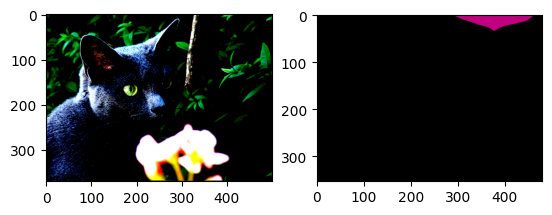

In [21]:
plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

### 1.3 Upsampling method with CNNs

#### 1.3.1 Transposed Convolution

<img src="https://drive.google.com/uc?export=view&id=1olTrk2Hu1dAppF2zxFVedy0aIrAbYrAw"  onerror="this.style.display='none'" /><br><br>

- The transposed convolution (it is often called as "deconvolution") is used to up-sample the input resolution by using learnable filters. In contrast to the standard convolution, which aggregates spatial information to a single point, it spreads a point of the input over multiple spatial locations.
- For example, a $3\times3$ kernel with a stride of 2 converts the~$2\times2$~(cyan squares) input into the~$5\times5$~(blue squares) output.

#### 1.3.2 Dilated Convolution
<img src="https://drive.google.com/uc?export=view&id=1LxBcf7V_s7559Odw9JzPwXFpPYCXa4JT"  onerror="this.style.display='none'" /><br><br>
- The dilated convolution introduces 'a dilation rate' to the standard convolution.

- The dilation rate means a spacing value between elements of a kernel, which enlarges the receptive field without introducing additional parameters.

- For example, a $3\times3$ kernel with a dilation rate of 2 has the same receptive field as a $5\times5$ kernel while it still use 9 parameters only, compared to the $5\times5$ the uses 25 parameters.

## 2. [Lab] Semantic segmentation

### 2.1 Write a FCN8s model  [4 points]

<img src="https://drive.google.com/uc?export=view&id=1xLdKvbMZrszjG2nVqFV3AsJ0t4M-nEN6"  onerror="this.style.display='none'" /><br><br>

<p style='text-align:right;'>[<a href='https://medium.com/@wilburdes/semantic-segmentation-using-fully-convolutional-neural-networks-86e45336f99b'>source</a>]</p>

**Crop boundary example**

In [22]:
a = torch.ones((1, 1, 160, 140))
b = torch.ones((1, 1, 120, 120))

try:
    a + b
except:
    print('The size of tensors are different')
    print(a.size())
    print(b.size())

# crop boundary
a = a[:, :, 5: 5+b.size(2), 5:5+b.size(3)]

# add connection with weight
c = 0.01*a + b

The size of tensors are different
torch.Size([1, 1, 160, 140])
torch.Size([1, 1, 120, 120])


- Predict 1: $1\times1$ Conv(in: 4096, out: n_class)
- Predict 2: $1\times1$ Conv(in: 512, out: n_class), weight = 0.01
- Predict 3: $1\times1$ Conv(in: 256, out: n_class), weight = 0.0001

- Deconv 1: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 2: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 3: $16\times16$ Transposed Conv (in: n_class, out: n_class, stride: 8, biase: False)

In [23]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # VGG features
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        #############
        # CODE HERE #
        #############
        self.pool3 = self.features[:17]
        self.pool4 = self.features[17:24]
        
        self.predict1 = nn.Conv2d(4096, n_class, 1)
        self.predict2 = nn.Conv2d(512, n_class, 1)
        self.predict3 = nn.Conv2d(256, n_class, 1)
        
        self.deconv1 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        self.deconv2 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        self.deconv3 = nn.ConvTranspose2d(n_class, n_class, 16, stride=8, bias=False)
        
        self._initialize_weights()
        self.copy_params_from_vgg16()

    def _initialize_weights(self):
        self.features[0].padding = (100,100)

        for m in self.modules():
            if isinstance(m, nn.MaxPool2d):
                m.ceil_mode=True
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        #############
        # CODE HERE #
        #############
        
        # Features extraction
        pool3 = self.pool3(x)  
        pool4 = self.pool4(pool3)  
        
        # Fully Connected Layers
        conv5 = self.features(x)  
        fc6 = self.relu6(self.fc6(conv5))
        fc6 = self.drop6(fc6)
        fc7 = self.relu7(self.fc7(fc6))
        fc7 = self.drop7(fc7)

        # Predictions
        predict1 = self.predict1(fc7) 
        predict2 = self.predict2(pool4 * 0.01)  
        predict3 = self.predict3(pool3 * 0.0001)  

        # Deconvolutions
        up1 = self.deconv1(predict1)
        predict2_crop = predict2[:, :, :up1.size(2), :up1.size(3)]  
        add1 = up1 + predict2_crop 

        up2 = self.deconv2(add1)
        predict3_crop = predict3[:, :, :up2.size(2), :up2.size(3)]
        add2 = up2 + predict3_crop 

        output = self.deconv3(add2)
        output = output[:, :, :x.size(2), :x.size(3)] 

        return output

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [24]:
model = FCN8s().cuda()

**Data Loader functions**

In [25]:
import random
import os

def read_file(path_to_file):
    with open(path_to_file) as f:
        img_list = []
        for line in f:
            img_list.append(line[:-1])
    return img_list

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def flip(I, flip_p):
    if flip_p > 0.5:
        return np.fliplr(I)
    else:
        return I

def scale_im(img_temp, scale):
    new_dims = (int(img_temp.shape[0] * scale), int(img_temp.shape[1] * scale))
    return cv2.resize(img_temp, new_dims).astype(float)


def get_data(chunk, gt_path='data/lab4/gt', img_path='data/lab4/img'):
    assert len(chunk) == 1

    scale = random.uniform(0.5, 1.3)
    flip_p = random.uniform(0, 1)

    images = cv2.imread(os.path.join(img_path, chunk[0] + '.jpg')).astype(float)

    images = cv2.resize(images, (321, 321)).astype(float)
    images = scale_im(images, scale)
    images[:, :, 0] = images[:, :, 0] - 104.008
    images[:, :, 1] = images[:, :, 1] - 116.669
    images[:, :, 2] = images[:, :, 2] - 122.675
    images = flip(images, flip_p)
    images = images[:, :, :, np.newaxis]
    images = images.transpose((3, 2, 0, 1))
    images = torch.from_numpy(images.copy()).float()

    gt = cv2.imread(os.path.join(gt_path, chunk[0] + '.png'))[:, :, 0]
    gt[gt == 255] = 0
    gt = flip(gt, flip_p)

    dim = int(321 * scale)

    gt = cv2.resize(gt, (dim, dim), interpolation=cv2.INTER_NEAREST).astype(float)

    labels = gt[np.newaxis, :].copy()

    return images, labels

**Data load**

In [26]:
img_list = read_file('data/lab4/list/train_aug.txt')
data_list = []

for i in range(10):
    np.random.shuffle(img_list)
    data_list.extend(img_list)
data_gen = chunker(data_list, 1)

In [27]:
lr = 1e-5 # choose your lr

optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.zero_grad()
max_iter = 20000

### 2.2 Write train code and print loss [2 points]
- Use a cross-entropy loss.
- Print a training loss for every 100 iterations.
- Show that the training loss steadily decreases.

In [28]:
def loss_calc(out, label):
    #############
    # CODE HERE #
    #############
    criterion = nn.CrossEntropyLoss()
    return criterion(out, label)

[0 / 20000] Training loss: 0.091
[100 / 20000] Training loss: 3.126
[200 / 20000] Training loss: 1.781
[300 / 20000] Training loss: 1.881
[400 / 20000] Training loss: 1.541
[500 / 20000] Training loss: 1.648
[600 / 20000] Training loss: 1.629
[700 / 20000] Training loss: 1.492
[800 / 20000] Training loss: 1.646
[900 / 20000] Training loss: 1.366
[1000 / 20000] Training loss: 1.457
[1100 / 20000] Training loss: 1.556
[1200 / 20000] Training loss: 1.523
[1300 / 20000] Training loss: 1.400
[1400 / 20000] Training loss: 1.466
[1500 / 20000] Training loss: 1.291
[1600 / 20000] Training loss: 1.282
[1700 / 20000] Training loss: 1.278
[1800 / 20000] Training loss: 1.162
[1900 / 20000] Training loss: 1.188
[2000 / 20000] Training loss: 1.317
[2100 / 20000] Training loss: 1.228
[2200 / 20000] Training loss: 1.180
[2300 / 20000] Training loss: 1.185
[2400 / 20000] Training loss: 1.219
[2500 / 20000] Training loss: 1.300
[2600 / 20000] Training loss: 1.190
[2700 / 20000] Training loss: 1.054
[280

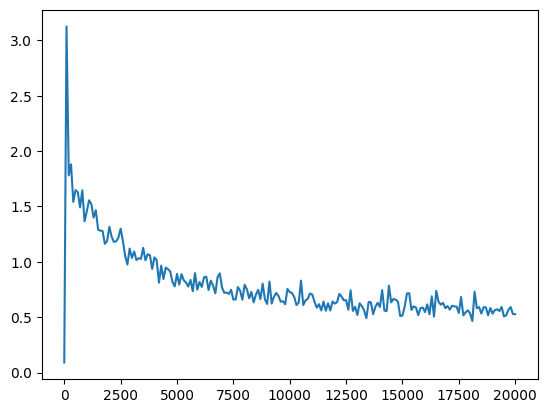

In [29]:
running_loss = 0.0

train_loss = []
iter_num = []

for iter in range(max_iter + 1):
    inputs, label = get_data(next(data_gen))

    #############
    # CODE HERE #
    #############
    inputs = inputs.cuda()
    label = torch.from_numpy(label).cuda().long()
    out = model(inputs)
    
    loss = loss_calc(out, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    running_loss += loss.item()
    if iter % 100 == 0:
        train_loss.append(running_loss / 100)
        iter_num.append(iter)
        print('[%d / %5d] Training loss: %.3f' % (iter, max_iter, running_loss / 100))
        running_loss = 0.0

plt.plot(iter_num, train_loss)
plt.show()

### 2.3 Discuss the result [3 points]
- Compare and Discuss the results. Note that it must contain the quantitative and qualitative results.
- Use the below 'validation_miou' function to evaluate your model. Your model should perform better than the example model **(0.5 mIoU)**.
- Use the above 'decode_label' function to visualize the network output.

In [30]:
def validation_miou(model):
    max_label = 20
    hist = np.zeros((max_label + 1, max_label + 1))

    def fast_hist(a, b, n):
        k = (a >= 0) & (a < n)
        return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

    val_list = open('data/lab4/list/val.txt').readlines()

    with torch.no_grad():
        for idx, i in enumerate(val_list):
            print('{}/{} ...'.format(idx + 1, len(val_list)))

            img = cv2.imread(os.path.join('data/lab4/img', i[:-1] + '.jpg')).astype(float)

            img[:, :, 0] -= 104.008
            img[:, :, 1] -= 116.669
            img[:, :, 2] -= 122.675

            data = torch.from_numpy(img.transpose((2,0,1))).float().cuda().unsqueeze(0)
            score = model(data)

            output = score.cpu().data[0].numpy().transpose(1, 2, 0)
            output = np.argmax(output, axis=2)
            gt = cv2.imread(os.path.join('data/lab4/gt', i[:-1] + '.png'), 0)

            hist += fast_hist(gt.flatten(), output.flatten(), max_label + 1)

        miou = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
        print("Mean iou = ", np.sum(miou) / len(miou))

    return np.sum(miou) / len(miou)

print(validation_miou(model))

1/1449 ...
2/1449 ...
3/1449 ...
4/1449 ...
5/1449 ...
6/1449 ...
7/1449 ...
8/1449 ...
9/1449 ...
10/1449 ...
11/1449 ...
12/1449 ...
13/1449 ...
14/1449 ...
15/1449 ...
16/1449 ...
17/1449 ...
18/1449 ...
19/1449 ...
20/1449 ...
21/1449 ...
22/1449 ...
23/1449 ...
24/1449 ...
25/1449 ...
26/1449 ...
27/1449 ...
28/1449 ...
29/1449 ...
30/1449 ...
31/1449 ...
32/1449 ...
33/1449 ...
34/1449 ...
35/1449 ...
36/1449 ...
37/1449 ...
38/1449 ...
39/1449 ...
40/1449 ...
41/1449 ...
42/1449 ...
43/1449 ...
44/1449 ...
45/1449 ...
46/1449 ...
47/1449 ...
48/1449 ...
49/1449 ...
50/1449 ...
51/1449 ...
52/1449 ...
53/1449 ...
54/1449 ...
55/1449 ...
56/1449 ...
57/1449 ...
58/1449 ...
59/1449 ...
60/1449 ...
61/1449 ...
62/1449 ...
63/1449 ...
64/1449 ...
65/1449 ...
66/1449 ...
67/1449 ...
68/1449 ...
69/1449 ...
70/1449 ...
71/1449 ...
72/1449 ...
73/1449 ...
74/1449 ...
75/1449 ...
76/1449 ...
77/1449 ...
78/1449 ...
79/1449 ...
80/1449 ...
81/1449 ...
82/1449 ...
83/1449 ...
84/1449 ...
8

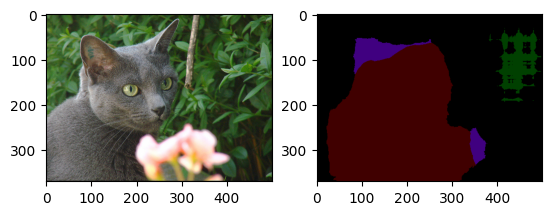

In [32]:
def decode_labels(mask, num_classes=21):
    from PIL import Image
    label_colours = [(0, 0, 0)
                 # 0=background
                 , (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128)
                 # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                 , (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0)
                 # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                 , (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128)
                 # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                 , (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
                 # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor

    h, w = mask.shape

    img = Image.new('RGB', (w, h))
    pixels = img.load()
    for j_, j in enumerate(mask[:, :]):
        for k_, k in enumerate(j):
            if k < num_classes:
                pixels[k_, j_] = label_colours[k]
    output = np.array(img)

    return output

img = cv2.imread('data/lab4/img/2009_005160.jpg').astype(float)
img_original = cv2.cvtColor(cv2.imread('data/lab4/img/2009_005160.jpg'), cv2.COLOR_BGR2RGB)
img[:, :, 0] -= 104.008
img[:, :, 1] -= 116.669
img[:, :, 2] -= 122.675
output=None
with torch.no_grad():
    data = torch.from_numpy(img.transpose((2,0,1))).float().cuda().unsqueeze(0)
    score = model(data)

    output = score.cpu().data[0].numpy().transpose(1, 2, 0)
    output = np.argmax(output, axis=2)
    output = decode_labels(output)

plt.subplot(1,2,1)
plt.imshow(img_original)
plt.subplot(1,2,2)
plt.imshow(output)

### *References*
[1] FCN official code (https://github.com/shelhamer/fcn.berkeleyvision.org)

[2] Upsampling method (https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

[3] Cs231n (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)